# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

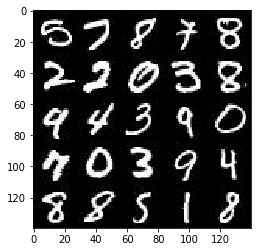

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

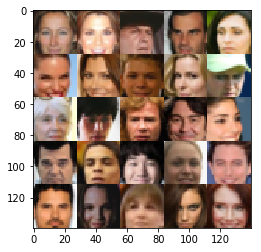

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Layer 1; convloution kernal = 5, subsample stride = 2, 32x32x3 => 16x16x32
        conv1 = tf.layers.conv2d(images, 32, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha*conv1, conv1) # Leaky RELU

        # Layer 2; convloution 16x16x32 => 8x8x64
        conv2 = tf.layers.conv2d(conv1, 64, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2) # Leaky RELU 

        # Layer 3; convloution 8x8x64 => 4x4x128
        conv3 = tf.layers.conv2d(conv2, 128, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3) # Leaky RELU

        # flatten the convolution to feed into the fully connected layers
        size = conv3.get_shape().as_list()
        feature_size = size[1]*size[2]*size[3] # get the number of features to fead into the NN 
        flatten = tf.reshape(conv3, (-1, feature_size))
        
        # Layer 4; Fully connect, 32x32x128 = 2048 => 512
        den1 = tf.layers.dense(flatten, feature_size//4, use_bias=False)
        den1 = tf.layers.batch_normalization(den1, training=True)
        den1 = tf.maximum(alpha*den1, den1)
        
        # Layer 5; Fully connect, 512 => 128
        den2 = tf.layers.dense(den1, feature_size//16, use_bias=False)
        den2 = tf.layers.batch_normalization(den2, training=True)
        den2 = tf.maximum(alpha*den2, den2)
        
        # Layer 6; Fully connect, 128 => 1
        logits = tf.layers.dense(den2, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope("generator", reuse=not is_train):
        alpha=0.2
        """
        # Layer 1; fully connected (z => 8192) => convolution (4 x 4 x 512)
        dens2 = tf.layers.dense(z, 7*7*512)
        conv1 = tf.reshape(dens2, (-1, 7, 7, 512)) # reshape to the first convolution layer
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        # Layer 2; convolution (8 x 8 x 512) => (16 x 16 x 256)
        conv3 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #res2 = tf.image.resize_images(conv3, [16,16])
        
        # Layer 3; convolution (28 x 28 x 128) => (28 x 28 x out_channel_dim)
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same')
        """
        # Dense Layer 1; Fully connect, z => 1024
        #den1 = tf.layers.dense(z, 1024, use_bias=False)
        #den1 = tf.layers.batch_normalization(den1, training=True)
        #den1 = tf.maximum(alpha*den1, den1)
        
        # Layer 1; fully connected (z => 8192) => convolution (4 x 4 x 512)
        dens2 = tf.layers.dense(z, 4*4*512)
        conv1 = tf.reshape(dens2, (-1, 4, 4, 512)) # reshape to the first convolution layer
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        # Layer 2; convolution (4 x 4 x 512) => (8 x 8 x 256)
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 3, strides=2, padding='same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        # Layer 3; convolution (8 x 8 x 256) => (16 x 16 x 128)
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        # Layer 4; convolution (16 x 16 x 128) => (32 x 32 x out_channel_dim)
        conv4 = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(conv4, [28,28])
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=0.1)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=0.1)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
    d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
            .minimize(d_loss, var_list=d_vars)
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                .minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)  
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # create tensorboard session at location log_path and save the graph there
        log_path = '/tmp/tensorboard/data/mnist'
        writer = tf.summary.FileWriter(log_path, graph=sess.graph)
    
        for epoch_i in range(epoch_count):
            for image in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                image = image*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(100, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: image, inputs_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, learn_rate: learning_rate})
                #_ = sess.run(g_opt, feed_dict={inputs_z: batch_z, learn_rate: learning_rate})
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: image})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                    
        # display rge output of the trained network
        show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode) 
        
        print("\nFinished")
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5558... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.5745
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.7588


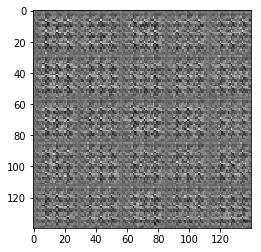

Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 0.8601
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 0.8720


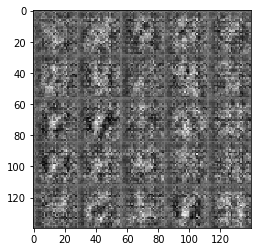

Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 0.9290
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 0.9213


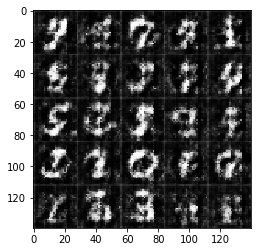

Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.9541
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 0.9331
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 0.9255
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 0.9951


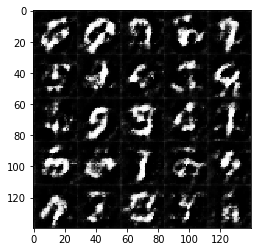

Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 1.0013
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.9789
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 0.9378
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 0.9824


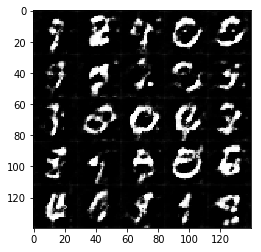

Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 1.0457
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 1.0740
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.9571
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.0079
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 0.9285


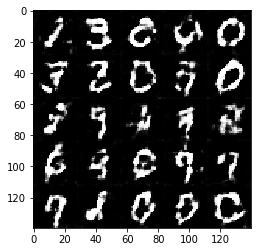

Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 1.0649
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 1.0673
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.0446
Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 1.0631
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.0301


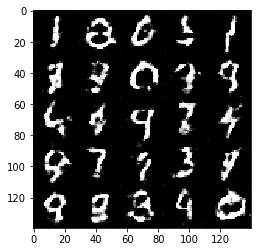

Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 1.0466
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 1.0244
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.0837
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 1.0018... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.1044


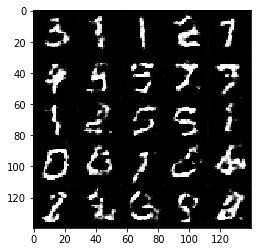

Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 1.0820
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 1.2141
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.1569
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 0.9941
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.2443
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 1.0436
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 1.1803
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.0464


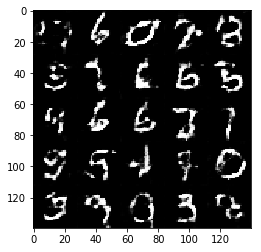

Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.2539
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.1764
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.1822


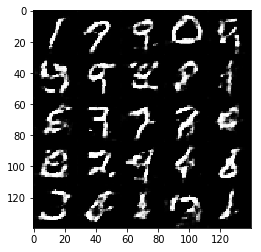


Finished


In [37]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.9259


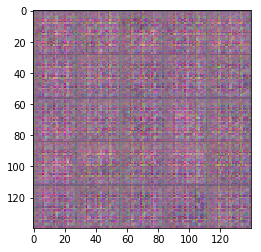

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8715


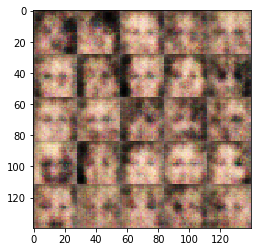

Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8328


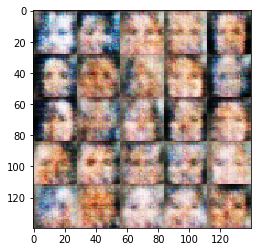

Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8352


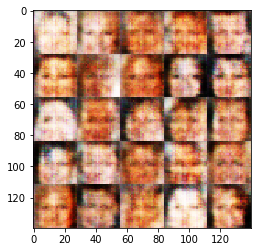

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.8407


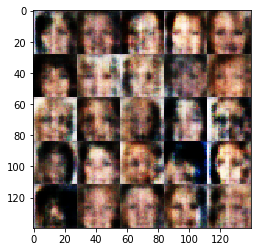

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8255


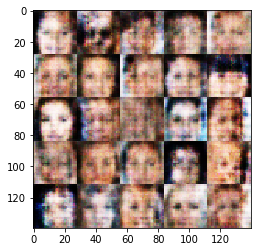

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8307


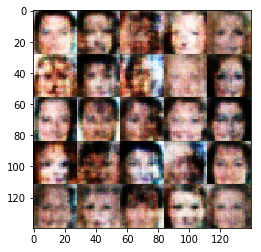

Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7951


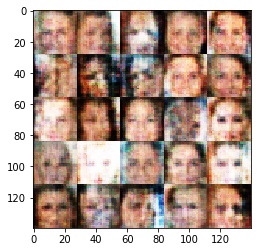

Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8113


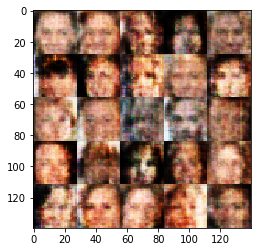

Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8811


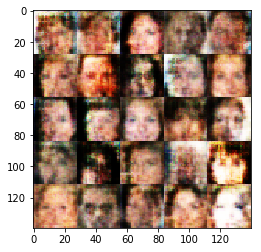

Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8440


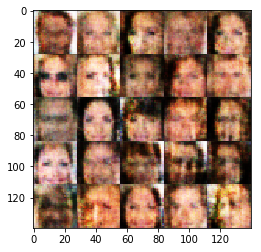

Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.8875


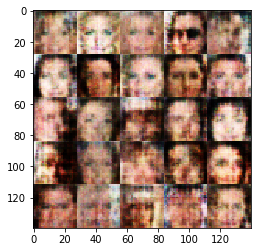

Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8524


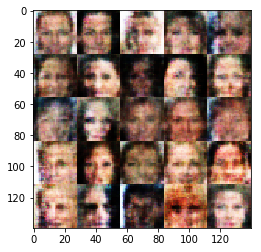

Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7852


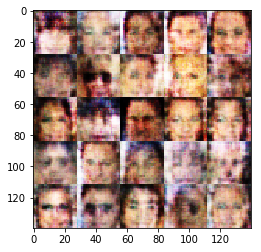

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8429


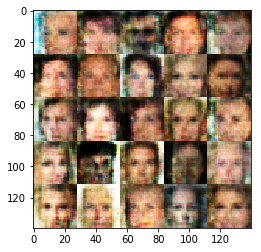

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8132


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001 
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.